<a href="https://colab.research.google.com/github/mmoudgalya/Google-Coding-Challenge-BN2021/blob/main/Copy_of_tensorflow_CNN_tutorial_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this exercise you will be filling in some blanks in the code needed to make a CNN to classify MNIST digits.

You will find various parts of the code that I have replaced with `None`. Use the information given in the boxes before the code to replace these `None` with the required functions. You can run each individual block of code as you go to check that it is doing something sensible.

If you get stuck then please ask one of the tutors, but if you are looking at this again later then you can find a working example [here](https://colab.research.google.com/drive/1wstjn9Yipp703EZW_iHBNClQDSz3ZwuU?usp=sharing)

# Creating your first CNN

We will create a convolutional neural network to classify hand-written digits. This is a classic example making use of the MNIST dataset, and it is the job that the very first CNN was designed to do.

We will make a simple network with two convolutional layers that will look something like the following:

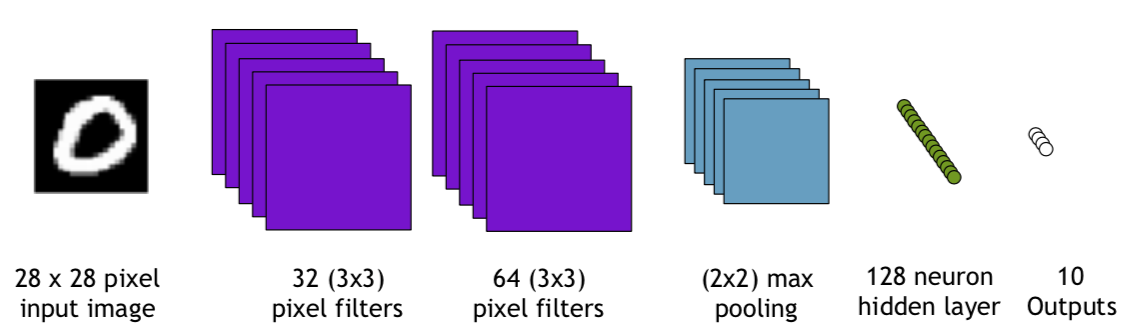



The first step is to include a few libaries that we will make use of. We will be making use of **tensorflow** and **keras** (a higher level much friendlier user interface for tensorflow).

# Some brief notes on the classes we are importing:

`keras.datasets` lets us import the MNIST dataset that we want to use

The import from `keras.model` is a class called `Sequential` and it is a type of neural network model that we can simple add layers to in the order that we require. It is probably the simplest way to build a model.

The imports from `keras.layers` are the types of layers that will be used to build our model. You should recognise these layers from the lecture.
*   `Conv2D`: the layer that performs 2D convolutions
*   `MaxPooling2D`: the pooling layer that downsamples the images
*   `Dense`: the *fully-connected* layer that you see in a standard artificial neural network / multi-layer perceptron
*   `Dropout`: as the name says, performs the dropout - switches off some random fraction fo nodes during training
*   `Flatten`: converts a tensor into a 1D tensor so that we can pass the output of the final 2D convolution into a dense layer.












In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
import numpy as np
import matplotlib.pyplot as plot

print('Tensorflow version:',tensorflow.__version__)

Tensorflow version: 2.9.2


Now we can define some variables that will come in useful. Many of these are the network *hyperparameters*.

In [2]:
# The batch size controls the number of images that are processed simultaneously
# It helps with computational efficiency
batch_size = 128
# Since we are classifying hand-written digits, we want to classify each image
# as one of ten values: 0, 1, 2, ... , 8, 9
num_classes = 10
# The number of epochs (iterations over the entire training set) that we want
# to train the network for
epochs = 1
# The learning rate is a very important hyperparameter, as discussed in the
# lecture. This is a fairly common default value to try
learning_rate = 0.001

# MNIST Dataset
The MNIST dataset is a standard dataset and can usefully be accessed directly from `keras`. Let's load the dataset and take a quick look at what we have.

11490434/11490434 [==============================] - 0s 0us/step
Shape of input array = (60000, 28, 28)
Input images have shape 28 x 28
There are 60000 images for training and 10000 images for testing
Example images with true classes [5 0 4 1 9]


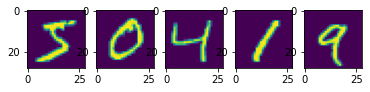

In [3]:
# Since MNIST is a standard dataset, we can just get it straight from keras.
# It is also split between train and test sets automatically
# - x_train is a numpy array that stores the training images
# - y_train is a numpy array that stores the true class of the training images
# - x_test is a numpy array that stores the testing images
# - y_test is a numpy array that stores the true class of the testing images
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Let's store the shape of the images for convenience
print("Shape of input array =",x_train.shape)
training_size = x_train.shape[0]
testing_size = x_test.shape[0]
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
print('Input images have shape',img_rows,'x',img_cols)
print('There are',training_size,'images for training and',testing_size,'images for testing')

# Let's take a look at a few example images from the training set
n_plots=5
print('Example images with true classes',y_train[0:n_plots])
fig, ax = plot.subplots(1, n_plots)
for plot_number in range (0,n_plots):
  ax[plot_number].imshow(x_train[plot_number])


# Data Preparation
Now we want to prepare the data and labels for training. This involves ensuring that we have:
*   The image depth as the final index. Image depth means the number of colour channels, and is 1 for MNIST since they are grey-scale images.
*   The true labels are a single number by default, but the loss function needs to have them in so-called *one-hot encoding* format.
*   `y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]`
*   `y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]`

Use the function `keras.utils.to_categorical(y,number_of_classes)` to do this for the training and test samples

You should have the following print outs from the block if all has gone correctly:

`x_train shape = (60000, 28, 28, 1)`

`y_train shape = (60000, 10)`

In [4]:
# We need to make sure the numpy arrays are in the correct format for the CNN
# These are 4D tensors where the first number is the number of images, the
# following two arguments are the image size, and the final one is the image 
# depth, which for greyscale is 1, and if these were rgb images, it would be 3
x_train = x_train.reshape(training_size,img_rows,img_cols,1)
x_test = x_test.reshape(testing_size,img_rows,img_cols,1)

# The y_train and y_test values we loaded also need to be modified.
# These values store the true classification of the images (0-9) as a single 
# number. We need to convert the single value into an array of length 10
# corresponding to the number of output classes. Thus values of 
# y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]
# y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

# Let's just check the shapes
print('x_train shape =',x_train.shape)
print('y_train shape =',y_train.shape)

x_train shape = (60000, 28, 28, 1)
y_train shape = (60000, 10)


# Creating the Model

Now it is time to actually build the model. We use the simple sequential model type that allows us to just sequentially add layers to the network using the `model.add()` function. The model class takes care of passing the output of one layer into the input of the next layer. 

As the picture at the top showed, we want to make a network with the following ten layers:

1.   2D convolution with 32 filters of size 3x3 pixels and stride 1
2.   2D convolution with 64 filters of size 3x3 pixels and stride 1
3.   Max pooling layer to pool regions of 2x2 pixels
4.   Dropout layer to switch off 25% of neurons
5.   Flatten the output into a 1D tensor
6.   Dense layer with 128 neurons
7.   Droput layer to switch off 50% of neurons
8.   Dense layer with 10 neurons for the classification

We will apply the `relu` activation function to the 2D convolutional layers and the first dense layer. The final layer will use a `softmax` activation to ensure the ten output values sum to one. Below are some hints on which functions to make use of - I will only include some of the arguments (the ones that we need here) so please click the links to the documentation if you want to see the full list.

---

[2D Convolution:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

`Conv2D(filters=<num_filters>, kernel_size=<filter_size>, strides=<stride>, padding=<padding> activation=<activation_function>)`

*   For the first layer of the network we need to specify the shape of the inputs. For all other layers the `Sequential` class takes care of it all. This means for the first layer we need to include the argument `input_shape=<image_shape>` in the Conv2D function call
*   We will use the default value for padding:  `padding='valid'` so you can omit this from the function call if you wish
*   We will also use the default stride: `strides=(1,1)` 
---
[2D Max Pooling:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

`MaxPooling2D(pool_size=<pool_size>, padding=<padding>)`
*   We want to pool pixels within a 2x2 block: `pool_size=(2,2)`
*   As with the convolutions, we want to use `valid` padding (the default value here again)

---
[Dropout:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

`Dropout(rate=<rate>)`
*   `rate` is the fraction of neurons to switch off

---
[Flatten:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

`Flatten()`
* Doesn't require any arguments
---

[Dense:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

`Dense(units=<number_of_neurons>, activation=<activation_function>)`
*    The number of neurons is given by `units`
*    Use `relu` as the activation for the first dense layer, and `softmax` for the second
---

If all has gone correctly you will see the following output that gives you the summary of the CNN architecture:

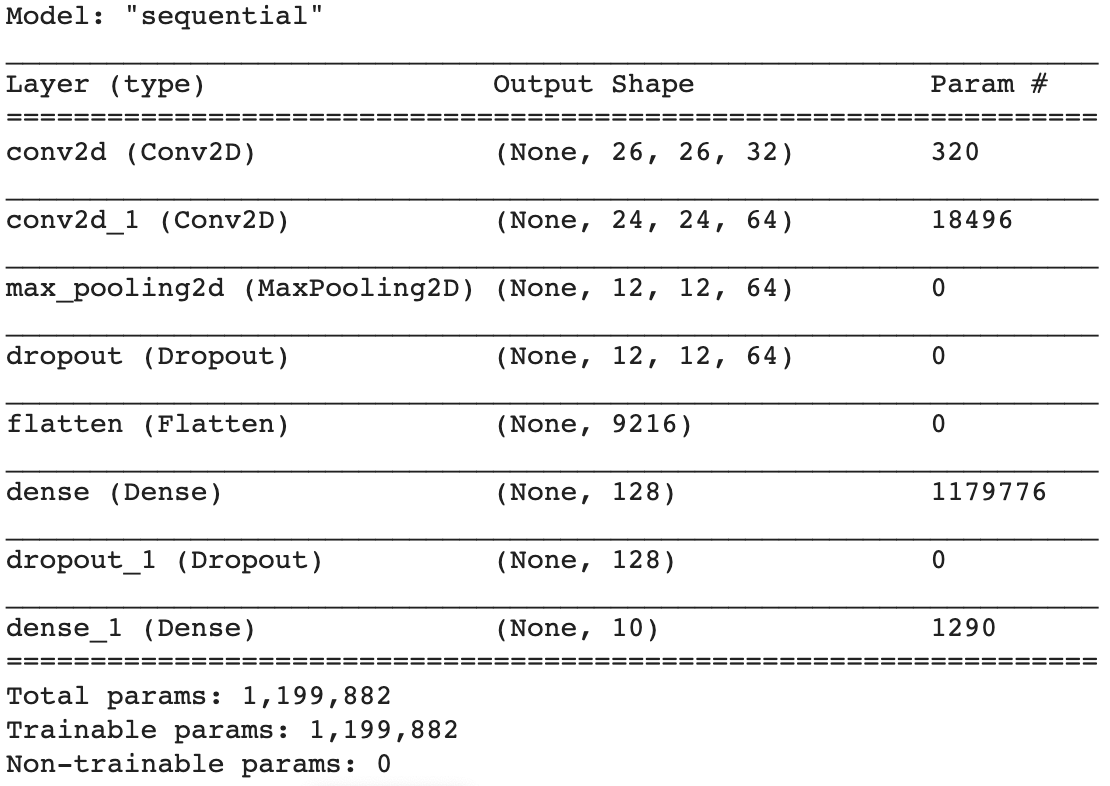

In [5]:
# Now we get to define our neural network
model = Sequential()
# The first convolutional layer needs to know what size images it will operate
# on, as given by the input_shape variable. Here we apply a vector of 32 
# filters of size (3,3) pixels. The 'relu' function provides some non-
# linearity, feel free to read up on other activation functions
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows,img_cols,1)))
# Now we add a second convolutional layer, this time with 64 (3,3) filters
# Use the relu activation function as above. We don't need to provide the
# input shape for any of the following layers as the sequential model
# knows to pass the output of the previous layer to the current one
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
# Pooling layers downsample the images - in this case 2x2 pixels become 
# one pixel. Specifically, we use a MaxPooling2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout disables some of the neurons to prevent overtraining.
# We will use a dropout fraction of 0.25.
model.add(Dropout(rate=0.25))
# We flatten the images into a single vector to pass into the dense
# layers
model.add(Flatten())
# The dense layer is what you have seen from a standard neural network
# We will use a dense layer with 128 nodes and the relu activation
model.add(Dense(units=128, activation='relu'))
# More dropout to avoid overtraining, this time with a fraction of 0.5
model.add(Dropout(rate=0.5))
# The final layer is a dense layer containing (num_classes) nodes.
# Using a softmax activation ensures that the sum of these 10 outputs is 1. 
model.add(Dense(units=num_classes, activation='softmax'))
# Let's have a look at our model to check it has come together as we expect
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Now we need to choose the loss function and the optimiser and compile the network so that it is ready to use. You will need to use the following information to provide the correct loss function and optimiser for the code below.

The loss function to use for classification tasks is called *categorial cross-entropy*. Note that if you only have two output choices (instead of the 10 we have hear), the simplified *binary-cross-entropy* loss function is the one to use.

*   `keras` gives us the loss function that we want: `keras.losses.categorical_crossentropy`
  * Note that we are setting the loss function, not executing the function, so we don't need the `()` that would call the function.
* There are a number of optimisers that we can use. In this case I have chosen to use Adam.
  * `keras` provides the implementation: `keras.optimizers.Adam(learning_rate=learning_rate)`
  *    There are other parameters that can be set, but I just show the learning rate here.

In [6]:
# Now we build the model, defining the loss function,
# optimiser (I typically use Adam) 
# Learning rate(learning_rate) is a parameter that we can optimise to help
# convergence - remember that we defined this near the start of the script. 
# We use categorical cross entropy loss, which is the one
# to use for a classification task with more than two classes.
loss_function = keras.losses.categorical_crossentropy
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
# We compile the model and tell it which loss function and optimiser to use
model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])


# Training the CNN

Now that we've got things set up, it's time for you to actually train the CNN! It is a single function call using the `fit` function of the model class. As before, I only give the arguments in this example that you need to set. See the documentation link below if you want to see everything.
* `fit(x=<train_images>, y=<train_labels>, batch_size=<batch_size>, epochs=<epochs> verbose=<verbose_level>, validation_data=(<validation_images,validation_labels>))`
  * I recommend using verbose=1 here
  
Full documentation of the fit function (from the Model class from which Sequential inherits) can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [8]:
# Now it is time to actually train the model using the training data with the 
# true target outputs from MNIST. Use model.fit(...) here. In this case we will
# the test sample for validation
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))


469/469 [==============================] - 145s 307ms/step - loss: 1.0061 - accuracy: 0.8210 - val_loss: 0.0873 - val_accuracy: 0.9739


You have now trained your CNN, so we can test how well it works on some images. The function to use is the model's `evaluate` function. Note that this function is still using the truth label so it isn't how we would use the network on unseen images (you will see this in the next step).
* `evaluate(x=<test_images>, y=<test_labels>, verbose=<verbose_level>)`
  * I use `verbose=0` here, but feel free to set it to `1`

  Full details on the evaluate function can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=es#evaluate)

In [9]:
# Run the network on the test sample and see how we do.
# This should match the final validation print out 
# from the training as we are using the same test sample.
# We use the model.evaluate function that makes use of
# truth labels to gauge the performance to get the score variable
score = model.evaluate(x=x_test, y=y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08725117892026901
Test accuracy: 0.9739000201225281


Now let's have a look to see if we can find an image that was incorrectly classified. 

We need to use the model.predict() function that doesn't know the truth. This is the function you would use generally for running inference on unseen events or data events.

We only need to worry about the first argument here, but full details can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)

```
Predict(x=<input_images>)
```
Note that here we are only testing the first 1000 events to look for incorrect classifications. If we were testing for some generic dataset ```x``` then we can select a subset of the data simply by using ```x[:n]``` where ```n``` is the number of elements to look at. Specifically, ```x[:n]``` returns the sub-array of the first ```n``` elements of ```x``` 


In [10]:
# Make a list of incorrect classifications
incorrect_indices = []
# By default, let's check one thousand images from x_test.
# You can check more, up to the value of testing_size.
n_images_to_check = 1000
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. Remember to use the x[:n]
# notation mentioned above in the following function call
raw_predictions = model.predict(x=x_test[:n_images_to_check])
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical 
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

32/32 [==============================] - 1s 21ms/step
Number of images that were incorrectly classified = 28


Incorrect classification for image 115 : predicted = 9 with true = 4


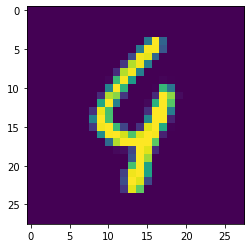

In [11]:
# Now you can modify this part to draw different images from the failures list
# The reshape just removes the depth dimension for drawing
im = 0
image_to_plot = x_test[incorrect_indices[im][0]].reshape(28,28)
fig, ax = plot.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot.reshape((28,28)))

# Saving the model

In a real situation we wouldn't be running inference in the same script as the training. We would save the model and then load it into another script where we analyse our data. 

First of all, let's save the model. There are a few different formats that you can look into, but I'll use ```.h5``` here as it stores the network as a single file. We use the model.save function which is described in more details [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save).

```model.save(<file_name>)```

Choose yourself a filename with a ```.h5``` extension

In [12]:
# Save the model as a .h5 file
model.save("CNN.h5")

# Loading the model

Now we load the model using a single call to:

```keras.models.load_model(<file_name>)```

where, of course, ```<file_name>``` matches the name used in the save function. Full details on this function can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model).

In [13]:
# Load the model and then print the summary to check it 
# looks how we expect
loaded_model = keras.models.load_model("CNN.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Now, let's just run over a few images to check things work. This time I am just processing one image at a time to show a different way of doing things. This is typically less efficient that processing the images together.

I've also separated the commands out less than before, stringing together functions more in single line commands.

In [14]:
for i in range(0,10):
  # Note that here I have to use reshape to prevent losing the first
  # dimension of the array when using x_test[i]. Otherwise
  # test_image would only have three dimensions (img_rows,img_cols,1)
  # and would be incompatible with the CNN input layer
  test_image = x_test[i].reshape(1,img_rows,img_cols,1)
  print('Predicted class =',np.argmax(loaded_model.predict(test_image)),
        "True class =",np.argmax(y_test[i]))

1/1 [==============================] - 0s 141ms/step
Predicted class = 7 True class = 7
1/1 [==============================] - 0s 33ms/step
Predicted class = 2 True class = 2
1/1 [==============================] - 0s 33ms/step
Predicted class = 1 True class = 1
1/1 [==============================] - 0s 31ms/step
Predicted class = 0 True class = 0
1/1 [==============================] - 0s 63ms/step
Predicted class = 4 True class = 4
1/1 [==============================] - 0s 30ms/step
Predicted class = 1 True class = 1
1/1 [==============================] - 0s 20ms/step
Predicted class = 4 True class = 4
1/1 [==============================] - 0s 19ms/step
Predicted class = 9 True class = 9
1/1 [==============================] - 0s 19ms/step
Predicted class = 5 True class = 5
1/1 [==============================] - 0s 18ms/step
Predicted class = 9 True class = 9
